<a href="https://colab.research.google.com/github/rakibulhaque9954/sentiment-analysis-imdb/blob/main/GRU_sentiment_analysis_imdb_rnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports


In [1]:
import tensorflow as tf### models
import numpy as np### math computations
import matplotlib.pyplot as plt### plotting bar chart
import sklearn### machine learning library
import cv2
from sklearn.metrics import confusion_matrix, roc_curve### metrics
import seaborn as sns### visualizations
import datetime
import pathlib
import io
import os
import re
import string
import time
from numpy import random
import gensim.downloader as api
from PIL import Image
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
from keras.models import Model
from keras.layers import Layer
from keras.layers import (Dense,Flatten,SimpleRNN,InputLayer,Conv1D,Bidirectional,GRU,LSTM,BatchNormalization,Dropout,Input, Embedding,TextVectorization)
from keras.losses import BinaryCrossentropy,CategoricalCrossentropy, SparseCategoricalCrossentropy
from keras.metrics import Accuracy,TopKCategoricalAccuracy, CategoricalAccuracy, SparseCategoricalAccuracy
from keras.optimizers import Adam
from google.colab import drive
from google.colab import files
from tensorboard.plugins import projector

# Data Preparation

In [30]:
train_dataset, val_dataset, test_dataset = tfds.load('imdb_reviews', split=['train', 'test[:50%]', 'test[50%:]'], as_supervised=True)


In [31]:
for review, label in train_dataset.take(10):
  print("Review", review)
  print("Label", label.numpy())



Review tf.Tensor(b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.", shape=(), dtype=string)
Label 0
Review tf.Tensor(b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I

In [32]:
def standardization(input_data):
  """Input: Raw Data(review, etc)
     Output: Standardized Data(review, etc)
     conversion to lower case for data regualrity,
     removal of html tags,
     regex means regularization text,
     removal of punctuations,
     removal of special characters,
     remove accented characters,
     stemming for example: discussion, discussed, discussing are the same word from the root discuss
     lemmatization for example: tensed when reduced to stem its tens which makes no sense, thats why lemmatization
     is used to provide the base for of the word, in this case tensed is turned into a lemma which is tense(again this two methods
     have their own use cases depending on the scenario)
  """
  lower_case = tf.strings.lower(input_data)
  html_tags = tf.strings.regex_replace(lower_case, '<[^>]+>', ' ')
  output = tf.strings.regex_replace(html_tags, '[%s]' % re.escape(string.punctuation), ' ')


  return output




In [33]:
standardization(tf.constant("<u>Okay,</u> you have:<br /><br />Penelope Keith as Miss Herringbone-Tweed, B.B.E. (Backbone of England.) She\'s killed off in the first scene - that\'s right, folks; this show has no backbone!<br /><br />Peter O\'Toole as Ol\' Colonel Cricket from The First War and now the emblazered Lord of the Manor.<br /><br />Joanna Lumley as the ensweatered Lady of the Manor, 20 years younger than the colonel and 20 years past her own prime but still glamourous (Brit spelling, not mine) enough to have a toy-boy on the side. It\'s alright, they have Col."))

<tf.Tensor: shape=(), dtype=string, numpy=b' okay   you have   penelope keith as miss herringbone tweed  b b e   backbone of england   she s killed off in the first scene   that s right  folks  this show has no backbone   peter o toole as ol  colonel cricket from the first war and now the emblazered lord of the manor   joanna lumley as the ensweatered lady of the manor  20 years younger than the colonel and 20 years past her own prime but still glamourous  brit spelling  not mine  enough to have a toy boy on the side  it s alright  they have col '>

#Tokenization and Numericalization(Text Vectorization)

In [34]:
VOCABULARY_SIZE = 10000 # common and important 10000 words
SEQUENCE_LENGTH = 250 # basically length of output



In [35]:
vectorize_layer = tf.keras.layers.TextVectorization(
    standardize=standardization,
    max_tokens=VOCABULARY_SIZE,
    output_mode='int',
    output_sequence_length=SEQUENCE_LENGTH,
)

In [36]:
training_data = train_dataset.map(lambda x, y: x) # takes in review, label and outputs only reviews
vectorize_layer.adapt(training_data)



In [37]:
print(vectorize_layer.get_vocabulary())
print(len(vectorize_layer.get_vocabulary()))


['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'it', 'in', 'i', 'this', 'that', 's', 'was', 'as', 'for', 'with', 'movie', 'but', 'film', 't', 'you', 'on', 'not', 'he', 'are', 'his', 'have', 'be', 'one', 'all', 'at', 'they', 'by', 'an', 'who', 'so', 'from', 'like', 'there', 'her', 'or', 'just', 'about', 'out', 'if', 'has', 'what', 'some', 'good', 'can', 'more', 'she', 'when', 'very', 'up', 'time', 'no', 'even', 'my', 'would', 'which', 'story', 'only', 'really', 'see', 'their', 'had', 'we', 'were', 'me', 'well', 'than', 'much', 'get', 'bad', 'been', 'people', 'will', 'do', 'other', 'also', 'into', 'first', 'great', 'because', 'how', 'him', 'don', 'most', 'made', 'its', 'then', 'make', 'way', 'them', 'could', 'too', 'movies', 'any', 'after', 'think', 'characters', 'character', 'watch', 'two', 'films', 'seen', 'many', 'life', 'being', 'plot', 'acting', 'never', 'love', 'little', 'best', 'where', 'over', 'did', 'show', 'know', 'off', 'ever', 'man', 'does', 'here', 'better', 'your', 'end

In [38]:
for review, label in train_dataset.take(1):
  print(review)
  print(label)

tf.Tensor(b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.", shape=(), dtype=string)
tf.Tensor(0, shape=(), dtype=int64)


In [39]:
def vectorizer(review, label):
  review = vectorize_layer(review)
  return review, label

In [40]:
train_dataset = train_dataset.map(vectorizer)
val_dataset = val_dataset.map(vectorizer)
test_dataset = test_dataset.map(vectorizer)





In [41]:
for review, label in train_dataset.take(1):
  print(review) # each token/word is given a id in the vocabulary as shown below
  print(label)

tf.Tensor(
[  11   14   35  429  392   18   89   21   29    1    9   34 1349 3254
   42  473    1  198   26   85  156   19   11  207  331   29   67  249
  214    9  474   59   67   85  113   97   24 5726   11   18   13  639
  762   11   18    7   35  396 8116  179 2455  416    2   90 1218  137
   70  147   54    2    1 7632   70  229   67 2941   16    1 2777    1
    1 1483 4948    3   41 3933  115 1581   17 3254   14  164   19    4
 1218  909 7983    9    4   18   12   14 4191    5  100  146 1211   10
  244  679   12   40   26   99   39   11 7120  272   13   39 1349 3254
   13   50  397   10   97 1195  857  145    8    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0 

In [42]:
BATCH_SIZE = 64

In [43]:
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)



# Modeling

# GRU(Gated Recurrent Unit) Multilayer and Bidirectional
<img src='https://www.researchgate.net/publication/323570767/figure/fig3/AS:674145788506118@1537740289540/The-diagram-of-a-GRU-cell.ppm'>

In [16]:

EMBEDDING_DIM = 64

model = tf.keras.Sequential([
  Input(shape=(SEQUENCE_LENGTH,)), # shape is 1d
  Embedding(VOCABULARY_SIZE, EMBEDDING_DIM),

  Bidirectional(GRU(64, return_sequences=True)), # return seqeunces will help in passing hidden states as an input for the next bidirectional layer
  Bidirectional(GRU(32)),

  Dense(64, activation='relu'),
  Dropout(0.5), # will help in overfitting
  Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 250, 64)           640000    
                                                                 
 bidirectional (Bidirection  (None, 250, 128)          49920     
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 64)                31104     
 onal)                                                           
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 6

In [18]:
checkpoint_filepath = '/content/drive/MyDrive/Colab Notebooks/RNN(sentiment analysis)/GRU/rnn.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [19]:
model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(1e-4), metrics=['accuracy'])


In [20]:

history = model.fit(train_dataset, validation_data=val_dataset, epochs=10, callbacks=[model_checkpoint_callback])


Epoch 1/10
391/391 [==============================] - 81s 177ms/step - loss: 0.6912 - accuracy: 0.5350 - val_loss: 0.6831 - val_accuracy: 0.5971
Epoch 2/10
  1/391 [..............................] - ETA: 19s - loss: 0.6832 - accuracy: 0.5938

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


391/391 [==============================] - 14s 37ms/step - loss: 0.4489 - accuracy: 0.7912 - val_loss: 0.3394 - val_accuracy: 0.8570
Epoch 3/10
391/391 [==============================] - 15s 37ms/step - loss: 0.2694 - accuracy: 0.9005 - val_loss: 0.3404 - val_accuracy: 0.8662
Epoch 4/10
391/391 [==============================] - 14s 36ms/step - loss: 0.2255 - accuracy: 0.9208 - val_loss: 0.3711 - val_accuracy: 0.8614
Epoch 5/10
391/391 [==============================] - 14s 37ms/step - loss: 0.1960 - accuracy: 0.9339 - val_loss: 0.3917 - val_accuracy: 0.8612
Epoch 6/10
391/391 [==============================] - 14s 37ms/step - loss: 0.1652 - accuracy: 0.9461 - val_loss: 0.4042 - val_accuracy: 0.8534
Epoch 7/10
391/391 [==============================] - 15s 38ms/step - loss: 0.1466 - accuracy: 0.9544 - val_loss: 0.4734 - val_accuracy: 0.8430
Epoch 8/10
391/391 [==============================] - 15s 37ms/step - loss: 0.1389 - accuracy: 0.9550 - val_loss: 0.4326 - val_accuracy: 0.8510
Epo

# Evaluation and Testing

In [21]:
test_dataset=test_dataset.batch(BATCH_SIZE)

In [22]:
model.evaluate(test_dataset)


196/196 [==============================] - 4s 18ms/step - loss: 0.4794 - accuracy: 0.8426


[0.479399174451828, 0.8426399827003479]

In [23]:
test_data = tf.data.Dataset.from_tensor_slices([["Overall, the movie was a missed opportunity. It had the potential to be an engaging and memorable film, but it ended up being a forgettable and frustrating viewing experience. I left the theater feeling disappointed and wishing I had chosen a different movie to watch."],
                                              ["very good start, but movie started becoming interesting at some point and fortunately at some point it started becoming much more fun, though there was too much background noise, so in all i liked this movie "],])






In [24]:
def vectorizer_test(review):
    return vectorize_layer(review)
test_dataset=test_data.map(vectorizer_test)

In [25]:
def positive_or_negative(prediction):
    if prediction > 0.5:
        return 'positive', prediction
    else:
        return 'negative', prediction


class_names = ['negative', 'positive']


In [26]:
predictions = model.predict(test_dataset)
for pred in predictions:
    value = positive_or_negative(tf.cast(pred, dtype=tf.float32))
    print(value)

2/2 [==============================] - 1s 12ms/step
('negative', <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.01090687], dtype=float32)>)
('positive', <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.8248978], dtype=float32)>)


# Confusion Matrix

In [ ]:
true_labels = []

predicted_labels = []

def predict_with_model(text_tensor):
    return model.predict(text_tensor)

# Iterate through the test dataset to collect true labels and make predictions
for text_tensor, label in test_dataset.take(2000):
    true_labels.append(label)
    # Expand dimensions to match the expected input shape
    text_tensor = tf.expand_dims(text_tensor, axis=0)
    predicted_label = predict_with_model(text_tensor)
    # binary classification with threshold 0.5
    predicted_label = 1 if predicted_label >= 0.5 else 0
    predicted_labels.append(predicted_label)

# Convert the true labels and predicted labels to numpy arrays
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)


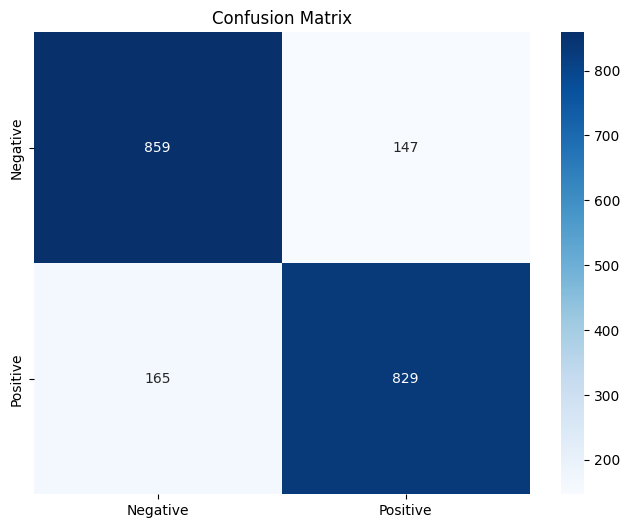

In [48]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Create the confusion matrix
confusion = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.title("Confusion Matrix")
plt.show()


# Model loss and accuracy

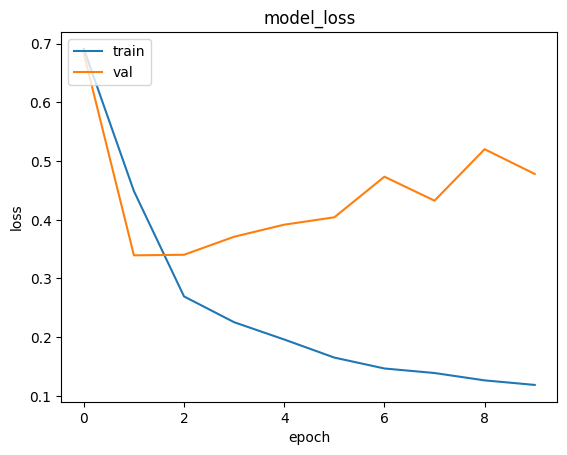

In [49]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

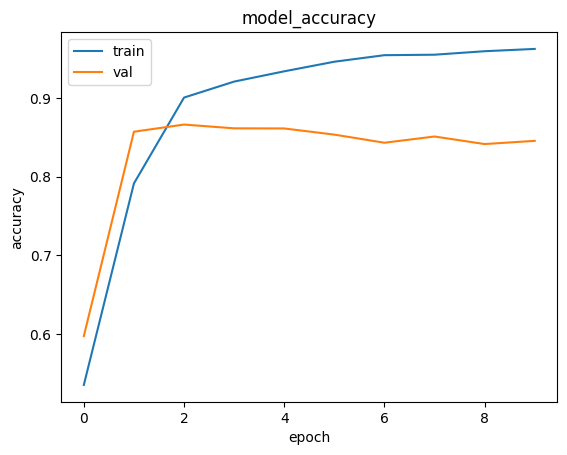

In [50]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model_accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Verdict

LSTM and GRU performance is very similar when evaluated, 84 % accuracy is quite good, the only difference is model weight, GRU is more preferrable in this scenario due to its light weight nature.